In [1]:
import torch
import torchvision
import torchvision.transforms as T
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import (
    fasterrcnn_resnet50_fpn,
    FastRCNNPredictor,
    AnchorGenerator,
    RPNHead
)
import torch.optim as optim
from tqdm import tqdm
from pathlib import Path
import time
import math
from PIL import Image
import json
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import gc
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from typing import Dict, List, Optional, Tuple
from collections import defaultdict, Counter
import threading
from queue import Queue
from contextlib import contextmanager
import time
import cv2
from FasterRCNN import utils
import pickle
import traceback
from torchvision.models.detection.image_list import ImageList
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class TACODataset(Dataset):
    def __init__(self, root_dir: str, annotation_file: str, transform=None, target_size: Tuple[int, int] = (640, 640)):
        super().__init__()
        self.root_dir = root_dir
        self.target_size = target_size
        self.transform = transform or T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            self.taco_data = json.load(f)
        
        # Create category mapping
        self.categories = {cat['id']: cat for cat in self.taco_data['categories']}
        
        # Filter and prepare image data
        self._prepare_dataset()
        
        print(f"Loaded {len(self.images)} valid images with annotations")
        self._print_category_distribution()
    
    def _print_category_distribution(self):
        """Print distribution of categories"""
        category_counts = {}
        for img_anns in self.annotations.values():
            for ann in img_anns:
                cat_id = ann['category_id']
                cat_name = self.categories[cat_id]['name']
                category_counts[cat_name] = category_counts.get(cat_name, 0) + 1
        
        print("\nCategory distribution:")
        for cat_name, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"{cat_name}: {count}")
    
    def _prepare_dataset(self):
        """Prepare dataset with valid images and annotations."""
        self.images = []
        self.annotations = {}
        
        for img in self.taco_data['images']:
            img_id = img['id']
            img_anns = [ann for ann in self.taco_data['annotations'] if ann['image_id'] == img_id]
            
            if img_anns:
                img_path = os.path.join(self.root_dir, img['file_name'])
                if os.path.exists(img_path):
                    self.images.append(img)
                    self.annotations[img_id] = img_anns

    def __len__(self) -> int:
        return len(self.images)

    def get_category_mapping(self):
        """Return mapping of category IDs to names"""
        return {cat['id']: cat['name'] for cat in self.taco_data['categories']}
    
    def _normalize_boxes(self, boxes: List[List[float]], image_size: Tuple[int, int]) -> List[List[float]]:
        """
        Normalize boxes to [0,1] range.
        
        Args:
            boxes: List of boxes in [x1, y1, x2, y2] format at target size
            image_size: Image size (width, height)
        Returns:
            List of normalized boxes in [0,1] range
        """
        w, h = image_size
        normalized_boxes = []
        
        for box in boxes:
            x1, y1, x2, y2 = box
            # Normalize to [0,1] range
            norm_box = [
                x1 / w,
                y1 / h,
                x2 / w,
                y2 / h
            ]
            # Clip to ensure values are in [0,1]
            norm_box = [max(0.0, min(1.0, coord)) for coord in norm_box]
            normalized_boxes.append(norm_box)
        
        return normalized_boxes
    
    def _resize_image_with_padding(self, image: np.ndarray, target_size: Tuple[int, int]) -> Tuple[np.ndarray, float, Tuple[int, int]]:
        """
        Resize image maintaining aspect ratio and add padding if necessary.
        Returns the resized image, scale factor, and padding values.
        """
        target_w, target_h = target_size
        orig_h, orig_w = image.shape[:2]
        
        # Calculate scaling factor to maintain aspect ratio
        scale = min(target_w / orig_w, target_h / orig_h)
        
        # Calculate new dimensions
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        
        # Calculate padding
        pad_w = (target_w - new_w) // 2
        pad_h = (target_h - new_h) // 2
        
        # Resize image
        resized = cv2.resize(image, (new_w, new_h))
        
        # Add padding
        padded = np.zeros((target_h, target_w, 3), dtype=np.uint8)
        padded[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized
        
        return padded, scale, (pad_w, pad_h)
    
    def _resize_boxes(self, boxes: List[List[float]], orig_size: Tuple[int, int], 
                     scale_factor: float, padding: Tuple[int, int]) -> List[List[float]]:
        """
        Resize boxes according to image scaling and padding.
        """
        pad_w, pad_h = padding
        resized_boxes = []
        
        for box in boxes:
            # Extract coordinates
            x1, y1, x2, y2 = box
            
            # Scale coordinates
            x1 = x1 * scale_factor + pad_w
            x2 = x2 * scale_factor + pad_w
            y1 = y1 * scale_factor + pad_h
            y2 = y2 * scale_factor + pad_h
            
            resized_boxes.append([x1, y1, x2, y2])
        
        return resized_boxes
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict]:
        # Get image info and load image 
        img_info = self.images[idx]
        img_id = img_info['id']
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image at {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get dimensions
        orig_h, orig_w = image.shape[:2]
        target_w, target_h = self.target_size
        
        # Calculate scaling and padding
        scale = min(target_w / orig_w, target_h / orig_h)
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        pad_x = (target_w - new_w) // 2
        pad_y = (target_h - new_h) // 2
        
        # Process annotations 
        img_anns = self.annotations[img_id]
        boxes = []
        labels = []
        areas = []
        iscrowd = []
        
        for ann in img_anns:
            x, y, w, h = map(float, ann['bbox'])
            
            if w > 0 and h > 0:
                # Scale coordinates
                x1 = (x * scale) + pad_x
                y1 = (y * scale) + pad_y
                x2 = ((x + w) * scale) + pad_x
                y2 = ((y + h) * scale) + pad_y
                
                # Normalize coordinates
                x1 = x1 / target_w
                x2 = x2 / target_w
                y1 = y1 / target_h
                y2 = y2 / target_h
                
                # Clip to [0,1]
                x1 = max(0.0, min(1.0, x1))
                x2 = max(0.0, min(1.0, x2))
                y1 = max(0.0, min(1.0, y1))
                y2 = max(0.0, min(1.0, y2))
                
                if x2 > x1 and y2 > y1:
                    boxes.append([x1, y1, x2, y2])
                    labels.append(ann['category_id'])
                    areas.append((x2 - x1) * (y2 - y1))
                    iscrowd.append(ann.get('iscrowd', 0))
        
        if not boxes:
            boxes = [[0, 0, 0.1, 0.1]]
            labels = [0]
            areas = [0.01]
            iscrowd = [0]
        
        # Resize and pad image
        image = cv2.resize(image, (new_w, new_h))
        padded = np.zeros((target_h, target_w, 3), dtype=np.uint8)
        padded[pad_y:pad_y+new_h, pad_x:pad_x+new_w] = image
        image = padded
        
        # Apply transforms
        image = self.transform(image)
        
        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([img_id]),
            'area': torch.tensor(areas, dtype=torch.float32),
            'iscrowd': torch.tensor(iscrowd, dtype=torch.int64)
        }
        
        return image, target

def collate_fn(batch):
    """
    Custom collate function for the modified TACO dataset that handles batching of 
    images and their corresponding target dictionaries.
    
    Args:
        batch: List of tuples (image, target) where:
            - image is a tensor of shape [3, H, W]
            - target is a dictionary containing:
                - boxes: tensor of shape [N, 4] in normalized coordinates
                - labels: tensor of shape [N]
                - image_id: tensor of shape [1]
                - area: tensor of shape [N]
                - iscrowd: tensor of shape [N]
    
    Returns:
        tuple: (images, targets) where:
            - images: tensor of shape [batch_size, 3, H, W]
            - targets: list of dictionaries, one per image
    """
    images = []
    targets = []
    
    for image, target in batch:
        images.append(image)
        targets.append(target)
    
    # Stack all images into a single tensor
    images = torch.stack(images, dim=0)
    
    return images, targets

In [3]:
def create_dataloaders(
    root_dir: str,
    annotation_file: str,
    train_batch_size: int = 8, 
    val_batch_size: int = 4,
    test_batch_size: int = 4,
    train_ratio: float = 0.7,
    val_ratio: float = 0.15,
    target_size: Tuple[int, int] = (640, 640),
    num_workers: int = 2
) -> Tuple[DataLoader, DataLoader, DataLoader, Dict[int, str]]:
    """
    Create dataloaders with memory-efficient settings for object detection
    """
    # Define transforms
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset
    full_dataset = TACODataset(
        root_dir=root_dir,
        annotation_file=annotation_file,
        transform=transform,
        target_size=target_size
    )
    
    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size
    
    # Create splits
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Create samplers
    train_sampler = SubsetRandomSampler(range(len(train_dataset)))
    val_sampler = SubsetRandomSampler(range(len(val_dataset)))
    test_sampler = SubsetRandomSampler(range(len(test_dataset)))
    
    # Create dataloaders with memory-efficient settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
        # prefetch_factor=2,
        # persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=val_batch_size,
        sampler=val_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=False,
        # prefetch_factor=2,
        # persistent_workers=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        sampler=test_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=False,
        # prefetch_factor=2,
        # persistent_workers=True
    )
    
    # Get category mapping from dataset
    category_mapping = full_dataset.get_category_mapping()
    
    # Print dataset information
    print("\nDataset Information:")
    print(f"Total samples: {total_size}")
    print(f"Training samples: {len(train_dataset)} ({train_ratio*100:.1f}%)")
    print(f"Validation samples: {len(val_dataset)} ({val_ratio*100:.1f}%)")
    print(f"Testing samples: {len(test_dataset)} ({(1-train_ratio-val_ratio)*100:.1f}%)")
    print("\nDataLoader Settings:")
    print(f"Train batch size: {train_batch_size}")
    print(f"Validation batch size: {val_batch_size}")
    print(f"Test batch size: {test_batch_size}")
    print(f"Number of workers: {num_workers}")
    
    return train_loader, test_loader, val_loader, category_mapping

In [4]:
def visualize_dataset_samples(train_dataset, val_dataset, test_dataset, category_mapping, 
                            samples_per_split=2, figsize=(8, 8)):
    """
    Visualize samples with proper coordinate denormalization
    """
    def create_minimal_loader(dataset):
        return DataLoader(
            dataset,
            batch_size=1,
            shuffle=True,
            num_workers=0,
            pin_memory=False,
            collate_fn=collate_fn
        )
    
    def denormalize_image(image):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return image * std + mean
    
    def plot_single_sample(image, target, split_name, sample_idx):
        # Create figure
        plt.figure(figsize=figsize)
        
        # Denormalize and convert image
        img_display = denormalize_image(image)
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)
        
        # Display image
        plt.imshow(img_display)
        
        # Create color map
        unique_labels = torch.unique(target['labels'])
        num_categories = len(unique_labels)
        colors = plt.cm.rainbow(np.linspace(0, 1, num_categories))
        color_map = dict(zip(unique_labels.numpy(), colors))
        
        # Get image dimensions
        height, width = img_display.shape[:2]
        print(f"\nProcessing {split_name} sample {sample_idx + 1}")
        # print(f"Image shape: {img_display.shape}")
        
        # Plot boxes
        boxes = target['boxes']
        labels = target['labels']
        
        for box, label in zip(boxes, labels):
            # Get normalized coordinates
            x1, y1, x2, y2 = box.numpy()
            # print(f"Normalized coords: ({x1:.3f}, {y1:.3f}, {x2:.3f}, {y2:.3f})")
            
            # Convert normalized coordinates to pixel coordinates
            x1_px = int(x1 * width)
            y1_px = int(y1 * height)
            x2_px = int(x2 * width)
            y2_px = int(y2 * height)
            
            # print(f"Pixel coords: ({x1_px}, {y1_px}, {x2_px}, {y2_px})")
            
            # Draw rectangle using pixel coordinates
            rect = patches.Rectangle(
                (x1_px, y1_px),
                x2_px - x1_px,
                y2_px - y1_px,
                linewidth=2,
                edgecolor=color_map[label.item()],
                facecolor='none'
            )
            plt.gca().add_patch(rect)
            
            # Add label
            label_text = category_mapping.get(label.item(), f"Class {label.item()}")
            plt.text(
                x1_px, y1_px - 5,
                label_text,
                color='white',
                fontsize=10,
                fontweight='bold',
                bbox=dict(
                    facecolor=color_map[label.item()],
                    edgecolor='none',
                    alpha=0.7,
                    pad=1
                )
            )
        
        plt.axis('off')
        plt.title(f"{split_name} Sample {sample_idx + 1}")
        plt.tight_layout()
        plt.show()
        plt.close()
    
    def visualize_split_samples(dataset, split_name, num_samples):
        if dataset is None:
            return
        
        for i in range(num_samples):
            # Create new loader for each sample
            loader = create_minimal_loader(dataset)
            images, targets = next(iter(loader))
            plot_single_sample(images[0], targets[0], split_name, i)
    
    # Visualize each split
    for dataset, name in [
        (train_dataset, "Training"),
        (val_dataset, "Validation"),
        (test_dataset, "Test")
    ]:
        visualize_split_samples(dataset, name, samples_per_split)

In [5]:
class DoubleConv(nn.Module):
    """
    Double Convolution block with optional batch norm and spatial dropout
    Input size remains constant: (H,W) -> (H,W)
    """
    def __init__(self, in_channels, out_channels, mid_channels=None, batch_norm=True, spatial_dropout=0.0):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
            
        layers = []
        # First conv block
        layers.extend([
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=not batch_norm),
            nn.BatchNorm2d(mid_channels) if batch_norm else nn.Identity(),
            nn.ReLU(inplace=True)
        ])
        
        if spatial_dropout > 0:
            layers.append(nn.Dropout2d(spatial_dropout))
            
        # Second conv block
        layers.extend([
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=not batch_norm),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            nn.ReLU(inplace=True)
        ])
        
        if spatial_dropout > 0:
            layers.append(nn.Dropout2d(spatial_dropout))
            
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """
    Modified UNet architecture for 640x640 input images
    Features:
    - Deeper network with additional downsampling steps
    - Adjusted feature map sizes for 640x640 input
    - Optional batch norm and spatial dropout
    - Size calculations for skip connections
    """
    def __init__(self, n_classes, n_channels=3, batch_norm=True, spatial_dropout=0.1):
        super().__init__()
        
        # Input: 640x640
        self.enc1 = DoubleConv(n_channels, 64, batch_norm=batch_norm, spatial_dropout=spatial_dropout)  # 640x640
        self.enc2 = DoubleConv(64, 128, batch_norm=batch_norm, spatial_dropout=spatial_dropout)        # 320x320
        self.enc3 = DoubleConv(128, 256, batch_norm=batch_norm, spatial_dropout=spatial_dropout)       # 160x160
        self.enc4 = DoubleConv(256, 512, batch_norm=batch_norm, spatial_dropout=spatial_dropout)       # 80x80
        self.enc5 = DoubleConv(512, 1024, batch_norm=batch_norm, spatial_dropout=spatial_dropout)      # 40x40
        
        # Bridge: 20x20
        self.bridge = DoubleConv(1024, 2048, batch_norm=batch_norm, spatial_dropout=spatial_dropout)
        
        # Decoder path
        self.up1 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)  # 40x40
        self.dec1 = DoubleConv(2048, 1024, batch_norm=batch_norm, spatial_dropout=spatial_dropout)
        
        self.up2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)   # 80x80
        self.dec2 = DoubleConv(1024, 512, batch_norm=batch_norm, spatial_dropout=spatial_dropout)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)    # 160x160
        self.dec3 = DoubleConv(512, 256, batch_norm=batch_norm, spatial_dropout=spatial_dropout)
        
        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)    # 320x320
        self.dec4 = DoubleConv(256, 128, batch_norm=batch_norm, spatial_dropout=spatial_dropout)
        
        self.up5 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)     # 640x640
        self.dec5 = DoubleConv(128, 64, batch_norm=batch_norm, spatial_dropout=spatial_dropout)
        
        # Final layer
        self.final = nn.Conv2d(64, n_classes, kernel_size=1)
        
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        """
        Forward pass with size annotations
        Input size: (B, C, 640, 640)
        """
        # Encoder path with sizes
        enc1 = self.enc1(x)         # (B, 64, 640, 640)
        p1 = self.pool(enc1)        # (B, 64, 320, 320)
        
        enc2 = self.enc2(p1)        # (B, 128, 320, 320)
        p2 = self.pool(enc2)        # (B, 128, 160, 160)
        
        enc3 = self.enc3(p2)        # (B, 256, 160, 160)
        p3 = self.pool(enc3)        # (B, 256, 80, 80)
        
        enc4 = self.enc4(p3)        # (B, 512, 80, 80)
        p4 = self.pool(enc4)        # (B, 512, 40, 40)
        
        enc5 = self.enc5(p4)        # (B, 1024, 40, 40)
        p5 = self.pool(enc5)        # (B, 1024, 20, 20)
        
        # Bridge
        bridge = self.bridge(p5)    # (B, 2048, 20, 20)
        
        # Decoder path with skip connections
        up1 = self.up1(bridge)      # (B, 1024, 40, 40)
        merge1 = torch.cat([enc5, up1], dim=1)  # (B, 2048, 40, 40)
        dec1 = self.dec1(merge1)    # (B, 1024, 40, 40)
        
        up2 = self.up2(dec1)        # (B, 512, 80, 80)
        merge2 = torch.cat([enc4, up2], dim=1)  # (B, 1024, 80, 80)
        dec2 = self.dec2(merge2)    # (B, 512, 80, 80)
        
        up3 = self.up3(dec2)        # (B, 256, 160, 160)
        merge3 = torch.cat([enc3, up3], dim=1)  # (B, 512, 160, 160)
        dec3 = self.dec3(merge3)    # (B, 256, 160, 160)
        
        up4 = self.up4(dec3)        # (B, 128, 320, 320)
        merge4 = torch.cat([enc2, up4], dim=1)  # (B, 256, 320, 320)
        dec4 = self.dec4(merge4)    # (B, 128, 320, 320)
        
        up5 = self.up5(dec4)        # (B, 64, 640, 640)
        merge5 = torch.cat([enc1, up5], dim=1)  # (B, 128, 640, 640)
        dec5 = self.dec5(merge5)    # (B, 64, 640, 640)
        
        # Final layer
        out = self.final(dec5)      # (B, n_classes, 640, 640)
        
        return out

In [6]:
def create_segmentation_masks(targets):
    """
    Create segmentation masks directly at 640x640
    """
    batch_size = len(targets)
    masks = torch.zeros((batch_size, 640, 640), dtype=torch.long)
    
    for idx, target in enumerate(targets):
        boxes = target['boxes']
        for box in boxes:
            # Scale normalized coordinates directly to 640x640
            x1, y1, x2, y2 = box
            x1 = int(x1 * 640)
            x2 = int(x2 * 640)
            y1 = int(y1 * 640)
            y2 = int(y2 * 640)
            
            # Ensure coordinates are within bounds
            x1 = min(max(0, x1), 639)
            x2 = min(max(0, x2), 639)
            y1 = min(max(0, y1), 639)
            y2 = min(max(0, y2), 639)
            
            if x2 > x1 and y2 > y1:
                masks[idx, y1:y2, x1:x2] = 1
    
    return masks

def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    from tqdm import tqdm
    import os
    from torch.cuda.amp import autocast, GradScaler
    
    os.makedirs('./UNet', exist_ok=True)
    
    # Initialize mixed precision training
    scaler = GradScaler()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    model = model.to(device)
    best_val_loss = float('inf')
    
    print("\nStarting training with mixed precision...")
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for images, targets in train_progress:
            images = images.to(device, non_blocking=True)
            
            # Create masks efficiently
            batch_size = images.shape[0]
            masks = torch.zeros((batch_size, 640, 640), 
                              dtype=torch.long, 
                              device=device)
            
            # Batch process boxes
            for i, target in enumerate(targets):
                boxes = target['boxes']
                coords = (boxes * 640).long()
                for x1, y1, x2, y2 in coords:
                    x1, x2 = x1.clamp(0, 639), x2.clamp(0, 639)
                    y1, y2 = y1.clamp(0, 639), y2.clamp(0, 639)
                    masks[i, y1:y2, x1:x2] = 1
            
            # Mixed precision training
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            optimizer.zero_grad(set_to_none=True)  # Slightly faster than zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            train_progress.set_postfix({'loss': f'{loss.item():.4f}'})
            
            # Efficient memory clearing
            del outputs, loss
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        
        with torch.no_grad(), autocast():
            for images, targets in val_progress:
                images = images.to(device, non_blocking=True)
                batch_size = images.shape[0]
                
                masks = torch.zeros((batch_size, 640, 640), 
                                  dtype=torch.long, 
                                  device=device)
                
                for i, target in enumerate(targets):
                    boxes = target['boxes']
                    coords = (boxes * 640).long()
                    for x1, y1, x2, y2 in coords:
                        x1, x2 = x1.clamp(0, 639), x2.clamp(0, 639)
                        y1, y2 = y1.clamp(0, 639), y2.clamp(0, 639)
                        masks[i, y1:y2, x1:x2] = 1
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                val_progress.set_postfix({'loss': f'{loss.item():.4f}'})
                del outputs, loss
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print('-' * 50)
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, './UNet/best_unet_model.pth')
            print(f'New best model saved! (Loss: {avg_val_loss:.4f})')

In [7]:
def create_segmentation_masks(targets):
    """
    Convert TACO dataset bounding box annotations to segmentation masks.
    This is a simplified version that creates rectangular masks from bounding boxes.
    """
    batch_size = len(targets)
    masks = torch.zeros((batch_size, 300, 300), dtype=torch.long)  # Assuming 300x300 target size
    
    for idx, target in enumerate(targets):
        boxes = target['boxes']
        for box in boxes:
            x1, y1, x2, y2 = (box * 300).long()  # Scale normalized coordinates to pixel space
            masks[idx, y1:y2, x1:x2] = 1  # Set box region to 1
            
    return masks

In [8]:
# Initialize dataset and model
data_folder = "F:/CMAPSS/DL/TACO-master/data"
annotation_file = os.path.join(data_folder,"annotations.json")

In [9]:
# Create dataloaders with conservative settings
train_loader, test_loader, val_loader, category_mapping = create_dataloaders(
    root_dir=data_folder, 
    annotation_file=annotation_file,
    train_batch_size=6,
    test_batch_size=1,
    num_workers=0,
    train_ratio=0.8,
    target_size = (640,640)
)

print(f"Number of categories: {len(category_mapping)}")

Loaded 1500 valid images with annotations

Category distribution:
Cigarette: 667
Unlabeled litter: 517
Plastic film: 451
Clear plastic bottle: 285
Other plastic: 273
Other plastic wrapper: 260
Drink can: 229
Plastic bottle cap: 209
Plastic straw: 157
Broken glass: 138
Styrofoam piece: 112
Glass bottle: 104
Disposable plastic cup: 104
Pop tab: 99
Other carton: 93
Normal paper: 82
Metal bottle cap: 80
Plastic lid: 77
Paper cup: 67
Corrugated carton: 64
Aluminium foil: 62
Single-use carrier bag: 61
Other plastic bottle: 50
Drink carton: 45
Tissues: 42
Crisp packet: 39
Disposable food container: 38
Plastic utensils: 37
Food Can: 34
Garbage bag: 31
Meal carton: 30
Rope & strings: 29
Paper bag: 27
Scrap metal: 20
Foam food container: 15
Foam cup: 13
Magazine paper: 12
Wrapping paper: 12
Egg carton: 11
Aerosol: 10
Metal lid: 10
Spread tub: 9
Food waste: 8
Squeezable tube: 7
Shoe: 7
Glass cup: 6
Glass jar: 6
Aluminium blister pack: 6
Other plastic container: 6
Toilet tube: 5
Six pack rings: 5



Processing Training sample 1


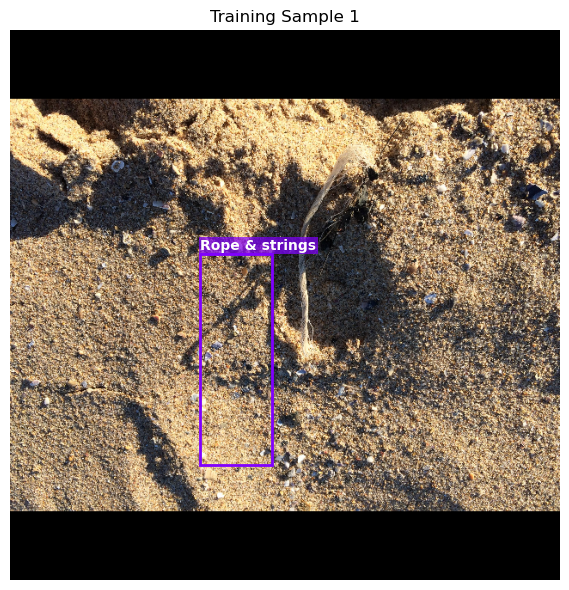


Processing Validation sample 1


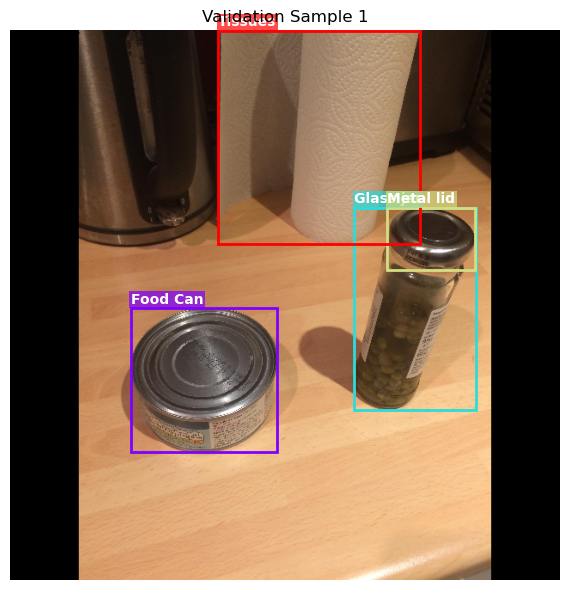


Processing Test sample 1


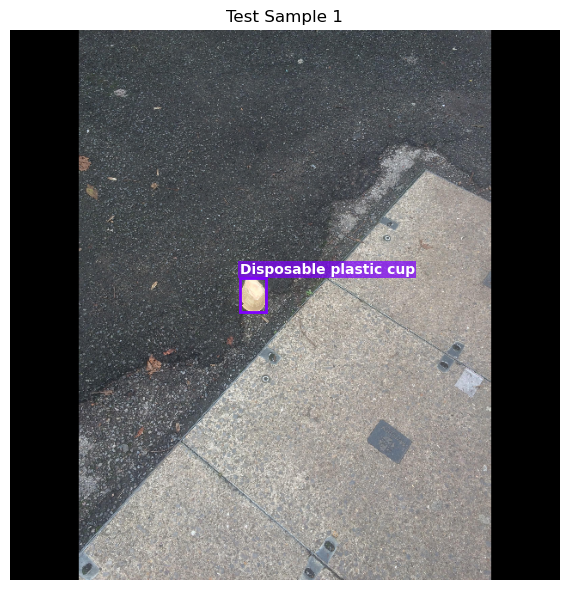

In [10]:
# Get datasets from your existing dataloaders
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset
test_dataset = test_loader.dataset

# Visualize samples
visualize_dataset_samples(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    category_mapping=category_mapping,
    samples_per_split=1,
    figsize=(8, 6)
)

In [11]:
# Initialize dataset and dataloaders (assuming they're already defined)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get number of classes from dataset
n_classes = len(category_mapping) + 1

# Initialize model
model = UNet(n_classes=n_classes)

# Train model
train_model(model, train_loader, val_loader, num_epochs=10, device=device)


Starting training with mixed precision...


Epoch 1/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:35<00:00,  1.59it/s, loss=1.5249]



Epoch 1/10
Training Loss: 2.6152
Validation Loss: 1.6822
--------------------------------------------------
New best model saved! (Loss: 1.6822)


Epoch 2/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:45<00:00,  1.25it/s, loss=0.5159]



Epoch 2/10
Training Loss: 1.0703
Validation Loss: 0.6245
--------------------------------------------------
New best model saved! (Loss: 0.6245)


Epoch 3/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:45<00:00,  1.25it/s, loss=0.3212]



Epoch 3/10
Training Loss: 0.4641
Validation Loss: 0.3140
--------------------------------------------------
New best model saved! (Loss: 0.3140)


Epoch 4/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:45<00:00,  1.24it/s, loss=0.3620]



Epoch 4/10
Training Loss: 0.2967
Validation Loss: 0.2153
--------------------------------------------------
New best model saved! (Loss: 0.2153)


Epoch 5/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:46<00:00,  1.24it/s, loss=0.0953]



Epoch 5/10
Training Loss: 0.2310
Validation Loss: 0.1761
--------------------------------------------------
New best model saved! (Loss: 0.1761)


Epoch 6/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:46<00:00,  1.24it/s, loss=0.0842]



Epoch 6/10
Training Loss: 0.1999
Validation Loss: 0.1520
--------------------------------------------------
New best model saved! (Loss: 0.1520)


Epoch 7/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:46<00:00,  1.23it/s, loss=0.0784]



Epoch 7/10
Training Loss: 0.1848
Validation Loss: 0.1498
--------------------------------------------------
New best model saved! (Loss: 0.1498)


Epoch 8/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:45<00:00,  1.25it/s, loss=0.0563]



Epoch 8/10
Training Loss: 0.1723
Validation Loss: 0.1323
--------------------------------------------------
New best model saved! (Loss: 0.1323)


Epoch 9/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:46<00:00,  1.24it/s, loss=0.0691]



Epoch 9/10
Training Loss: 0.1672
Validation Loss: 0.1279
--------------------------------------------------
New best model saved! (Loss: 0.1279)


Epoch 10/10 [Val]: 100%|██████████████████████████████████████████████████| 57/57 [00:45<00:00,  1.26it/s, loss=0.8457]


Epoch 10/10
Training Loss: 0.1630
Validation Loss: 0.1345
--------------------------------------------------


In [29]:
train_model(model, train_loader, val_loader, num_epochs=10, device=device)


Starting training with mixed precision...


Epoch 1/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:38<00:00,  1.47it/s, loss=0.2677]



Epoch 1/10
Training Loss: 0.1627
Validation Loss: 0.1245
--------------------------------------------------
New best model saved! (Loss: 0.1245)


Epoch 2/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:49<00:00,  1.15it/s, loss=0.4147]



Epoch 2/10
Training Loss: 0.1564
Validation Loss: 0.1220
--------------------------------------------------
New best model saved! (Loss: 0.1220)


Epoch 3/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:50<00:00,  1.13it/s, loss=0.6366]



Epoch 3/10
Training Loss: 0.1502
Validation Loss: 0.1234
--------------------------------------------------


Epoch 4/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:49<00:00,  1.16it/s, loss=0.1240]



Epoch 4/10
Training Loss: 0.1459
Validation Loss: 0.1183
--------------------------------------------------
New best model saved! (Loss: 0.1183)


Epoch 5/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:49<00:00,  1.16it/s, loss=0.0853]



Epoch 5/10
Training Loss: 0.1459
Validation Loss: 0.1152
--------------------------------------------------
New best model saved! (Loss: 0.1152)


Epoch 6/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:49<00:00,  1.15it/s, loss=0.0668]



Epoch 6/10
Training Loss: 0.1443
Validation Loss: 0.1111
--------------------------------------------------
New best model saved! (Loss: 0.1111)


Epoch 7/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:50<00:00,  1.14it/s, loss=0.0235]



Epoch 7/10
Training Loss: 0.1409
Validation Loss: 0.1106
--------------------------------------------------
New best model saved! (Loss: 0.1106)


Epoch 8/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:49<00:00,  1.14it/s, loss=0.1595]



Epoch 8/10
Training Loss: 0.1409
Validation Loss: 0.1141
--------------------------------------------------


Epoch 9/10 [Val]: 100%|███████████████████████████████████████████████████| 57/57 [00:49<00:00,  1.15it/s, loss=0.0173]



Epoch 9/10
Training Loss: 0.1408
Validation Loss: 0.1135
--------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████████████████████████████████████████████| 57/57 [00:49<00:00,  1.14it/s, loss=0.0228]



Epoch 10/10
Training Loss: 0.1385
Validation Loss: 0.1084
--------------------------------------------------
New best model saved! (Loss: 0.1084)


In [20]:

def clear_gpu_memory():
    """
    Clear GPU memory allocated by PyTorch
    """
    if torch.cuda.is_available():
        # Clear cache
        torch.cuda.empty_cache()
        # Reset peak memory stats
        torch.cuda.reset_peak_memory_stats()
        # Clear memory allocations
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj):
                    if obj.is_cuda:
                        del obj
            except:
                pass
        # Force garbage collection
        gc.collect()
        torch.cuda.empty_cache()
        print("GPU memory cleared")

def load_best_model(model_path, device):
    """
    Load the best saved model with correct number of classes
    """
    # First load the checkpoint to check the model structure
    checkpoint = torch.load(model_path)
    
    # Get number of output classes from the saved model
    n_classes = checkpoint['model_state_dict']['final.bias'].shape[0]
    print(f"Saved model has {n_classes} output classes")
    
    # Initialize model with correct number of classes
    model = UNet(n_classes=n_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print(f"Loaded model from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")
    return model

def visualize_segmentation(model, test_loader, device, category_mapping, num_samples=5):
    """
    Visualize exactly 5 samples with class names from category mapping
    """
    model.eval()
    count = 0
    
    with torch.no_grad():
        for images, targets in test_loader:
            if count >= num_samples:
                break
                
            for idx in range(images.shape[0]):
                if count >= num_samples:
                    break
                    
                # Process single image
                image = images[idx].to(device)
                target = targets[idx]
                
                # Get prediction
                output = model(image.unsqueeze(0))
                pred_mask = torch.argmax(output[0], dim=0).cpu().numpy()
                
                # Convert image for display
                img_display = image.cpu().permute(1, 2, 0).numpy()
                img_display = (img_display * np.array([0.229, 0.224, 0.225]) + 
                             np.array([0.485, 0.456, 0.406]))
                img_display = np.clip(img_display, 0, 1)
                
                # Create figure
                plt.figure(figsize=(12, 12))
                
                # Plot base image
                plt.imshow(img_display)
                
                # Overlay prediction mask
                pred_mask_colored = np.zeros((*pred_mask.shape, 4))
                pred_mask_colored[pred_mask == 1] = [1, 0, 0, 0.3]
                plt.imshow(pred_mask_colored)
                
                # Add ground truth boxes and labels
                boxes = target['boxes']
                labels = target['labels']
                
                for box, label_id in zip(boxes, labels):
                    x1, y1, x2, y2 = (box * 640).cpu().numpy()
                    
                    # Get class name from category mapping
                    class_name = category_mapping.get(label_id.item(), f"Class {label_id.item()}")
                    
                    # Draw box
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                      fill=False, 
                                      linestyle='--', 
                                      edgecolor='white',
                                      linewidth=2)
                    plt.gca().add_patch(rect)
                    
                    # Add class name with background box
                    plt.text(x1, y1-5, class_name, 
                           color='white', 
                           fontsize=10,
                           bbox=dict(facecolor='black', alpha=0.7))
                
                plt.title(f'Sample {count+1}/5')
                plt.axis('off')
                plt.tight_layout()
                plt.show()
                plt.close()
                
                count += 1

In [30]:
# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print("GPU memory cleared")

# Load model
print("Loading model...")
checkpoint = torch.load('./UNet/best_unet_model.pth')
n_classes = checkpoint['model_state_dict']['final.bias'].shape[0]
model = UNet(n_classes=n_classes)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
print(f"Model loaded with {n_classes} classes")

GPU memory cleared
Loading model...
Model loaded with 61 classes


In [ ]:
# Visualize exactly 5 samples
print("\nGenerating visualizations with class names...")
visualize_segmentation(model, test_loader, device, category_mapping, num_samples=10)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()